# Product Bundle Insights Dashboard

## Objective
This notebook presents key insights derived from the product bundle
recommendation pipeline, focusing on:

- Product co-purchase behavior
- Bundle strength and affinity
- Popularity vs relevance
- Temporal trends in bundling

The insights are designed for:
- Retail decision-makers
- Merchandising teams
- Product managers
- Customer-facing recommendation strategy

No modeling or evaluation is performed here.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)

In [2]:
BASE_DIR = Path().resolve().parent

clean_df = pd.read_parquet(
    BASE_DIR / "data" / "processed" / "clean_transactions.parquet"
)

co_df = pd.read_parquet(
    BASE_DIR / "data" / "features" / "weighted_co_occurrence.parquet"
)

popularity_df = pd.read_parquet(
    BASE_DIR / "data" / "features" / "product_popularity.parquet"
)

print("Artifacts loaded successfully.")

Artifacts loaded successfully.


## Insight 1: How many products do customers buy together?

Understanding basket size helps determine:
- Bundle size strategy
- Cross-sell limits


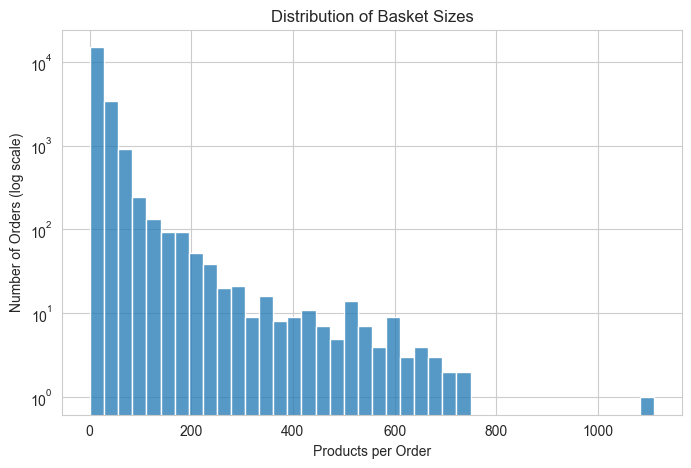

In [3]:
basket_sizes = (
    clean_df.groupby("InvoiceNo")["StockCode"]
            .nunique()
)

plt.figure(figsize=(8, 5))
sns.histplot(basket_sizes, bins=40)
plt.yscale("log")
plt.title("Distribution of Basket Sizes")
plt.xlabel("Products per Order")
plt.ylabel("Number of Orders (log scale)")
plt.show()

## Insight 2: Is revenue driven by few products or many?

This shows whether sales are dominated by a small number of items
or spread across a long tail.

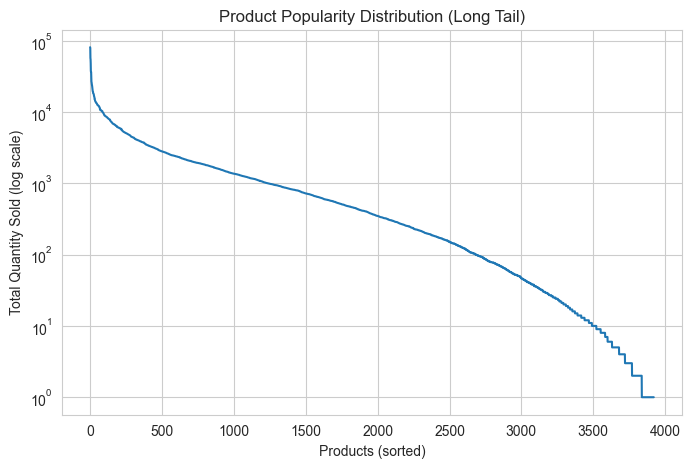

In [4]:
popularity_sorted = (
    popularity_df.sort_values("popularity", ascending=False)
)

plt.figure(figsize=(8, 5))
plt.plot(popularity_sorted["popularity"].values)
plt.yscale("log")
plt.title("Product Popularity Distribution (Long Tail)")
plt.xlabel("Products (sorted)")
plt.ylabel("Total Quantity Sold (log scale)")
plt.show()

## Insight 3: Which products are most strongly bought together?

These pairs represent high-confidence bundle opportunities.

In [5]:
top_bundles = (
    co_df.sort_values("weighted_score", ascending=False)
         .head(10)
)

top_bundles

,product_a,product_b,weighted_score
4104,22086,22910,301.591798
2198505,23300,23301,255.117407
274,22726,22727,244.645653
158874,22577,22578,244.514637
2155143,23203,85099B,238.223378
12352,22386,85099B,223.647711
136734,22697,22699,204.504058
6392,21931,85099B,203.257524
6853,20725,20727,200.061688
2155045,23202,23203,197.203537


In [6]:
product_name_map = (
    clean_df.groupby("StockCode")["Description"]
            .agg(lambda x: x.mode().iloc[0])
            .to_dict()
)

top_bundles.assign(
    product_a_name=top_bundles["product_a"].map(product_name_map),
    product_b_name=top_bundles["product_b"].map(product_name_map)
)[["product_a_name", "product_b_name", "weighted_score"]]

,product_a_name,product_b_name,weighted_score
4104,PAPER CHAIN KIT 50'S CHRISTMAS,PAPER CHAIN KIT VINTAGE CHRISTMAS,301.591798
2198505,GARDENERS KNEELING PAD CUP OF TEA,GARDENERS KNEELING PAD KEEP CALM,255.117407
274,ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE RED,244.645653
158874,WOODEN HEART CHRISTMAS SCANDINAVIAN,WOODEN STAR CHRISTMAS SCANDINAVIAN,244.514637
2155143,JUMBO BAG VINTAGE DOILY,JUMBO BAG RED RETROSPOT,238.223378
12352,JUMBO BAG PINK POLKADOT,JUMBO BAG RED RETROSPOT,223.647711
136734,GREEN REGENCY TEACUP AND SAUCER,ROSES REGENCY TEACUP AND SAUCER,204.504058
6392,JUMBO STORAGE BAG SUKI,JUMBO BAG RED RETROSPOT,203.257524
6853,LUNCH BAG RED RETROSPOT,LUNCH BAG BLACK SKULL.,200.061688
2155045,JUMBO BAG VINTAGE LEAF,JUMBO BAG VINTAGE DOILY,197.203537


## Insight 4: Are strong bundles just popular products?

This compares bundle strength against product popularity.

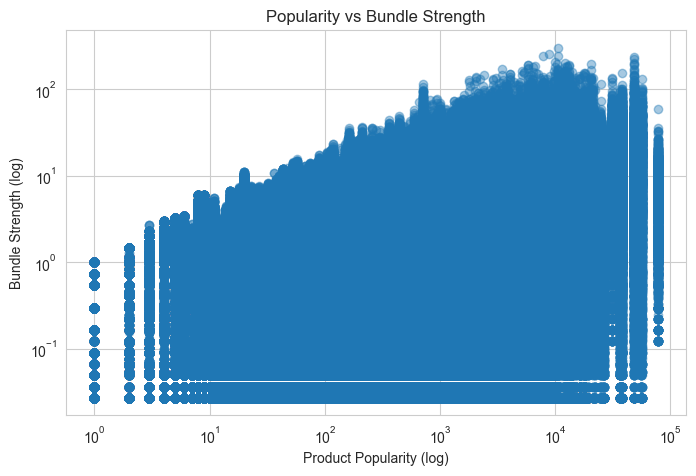

In [7]:
merged = co_df.merge(
    popularity_df,
    left_on="product_b",
    right_on="StockCode",
    how="left"
)

plt.figure(figsize=(8, 5))
plt.scatter(
    merged["popularity"],
    merged["weighted_score"],
    alpha=0.4
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Product Popularity (log)")
plt.ylabel("Bundle Strength (log)")
plt.title("Popularity vs Bundle Strength")
plt.show()

## Insight 5: Customer-Oriented Bundling

This shows how recommendations reflect actual shopping behavior.

In [8]:
example_product = top_bundles.iloc[0]["product_a"]

bundle_partners = (
    co_df[co_df["product_a"] == example_product]
    .sort_values("weighted_score", ascending=False)
    .head(5)
)

bundle_partners.assign(
    Recommended_Product=bundle_partners["product_b"].map(product_name_map)
)[["Recommended_Product", "weighted_score"]]

,Recommended_Product,weighted_score
4104,PAPER CHAIN KIT VINTAGE CHRISTMAS,301.591798
2520059,JUMBO BAG 50'S CHRISTMAS,165.910308
8665,SET OF 20 VINTAGE CHRISTMAS NAPKINS,144.307148
8669,60 CAKE CASES VINTAGE CHRISTMAS,141.169805
7677,POPCORN HOLDER,131.430057


## Insight 6: Seasonal Trends

Understanding seasonality helps align promotions and inventory.

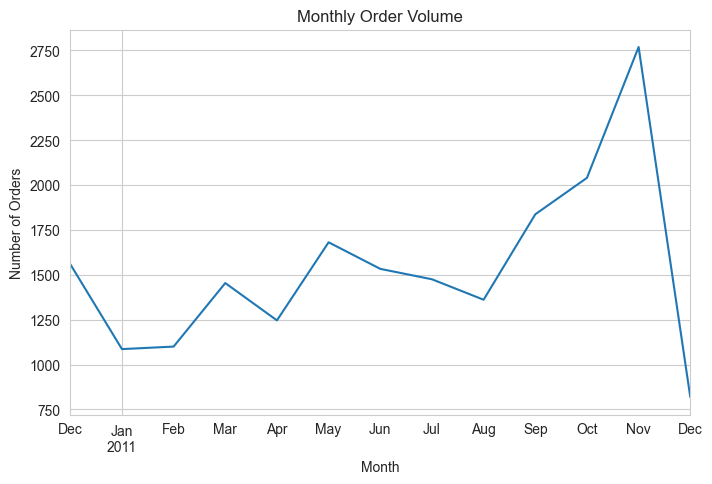

In [9]:
clean_df["month"] = clean_df["InvoiceDate"].dt.to_period("M")

monthly_orders = (
    clean_df.groupby("month")["InvoiceNo"]
            .nunique()
)

plt.figure(figsize=(8, 5))
monthly_orders.plot()
plt.title("Monthly Order Volume")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.show()

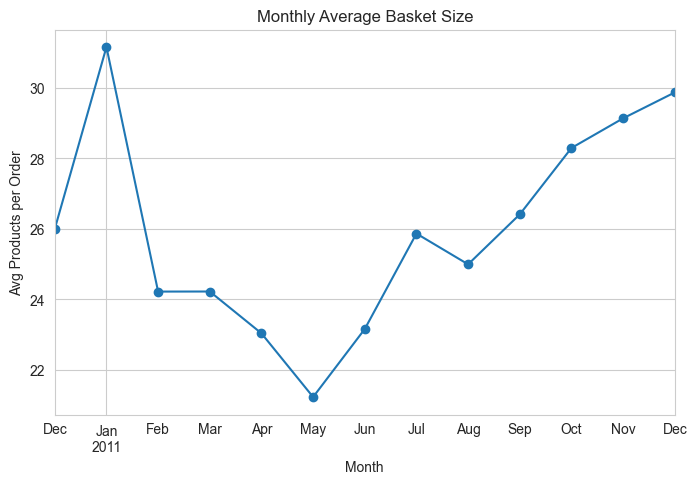

In [10]:
monthly_basket_size = (
    clean_df.groupby(["month", "InvoiceNo"])["StockCode"]
            .nunique()
            .groupby("month")
            .mean()
)

plt.figure(figsize=(8, 5))
monthly_basket_size.plot(marker="o")
plt.title("Monthly Average Basket Size")
plt.xlabel("Month")
plt.ylabel("Avg Products per Order")
plt.show()

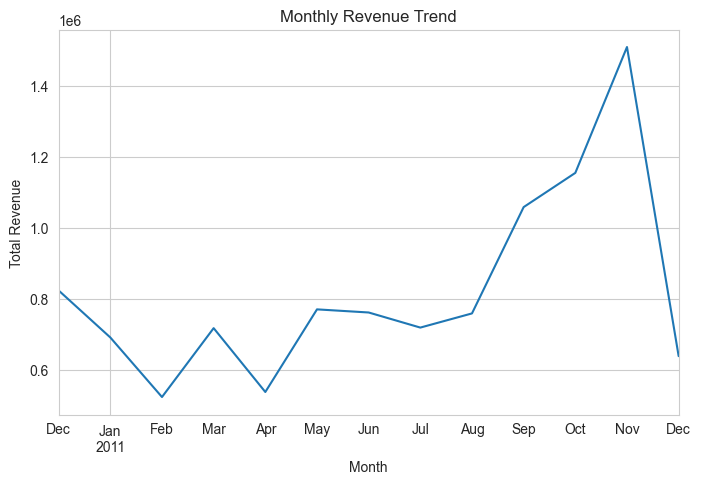

In [11]:
clean_df["revenue"] = clean_df["Quantity"] * clean_df["UnitPrice"]

monthly_revenue = (
    clean_df.groupby("month")["revenue"]
            .sum()
)

plt.figure(figsize=(8, 5))
monthly_revenue.plot()
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.show()

In [12]:
top_products_monthly = (
    clean_df.groupby(["month", "StockCode"])["Quantity"]
            .sum()
            .reset_index()
            .sort_values(["month", "Quantity"], ascending=[True, False])
            .groupby("month")
            .head(5)
)

top_products_monthly.assign(
    Product=top_products_monthly["StockCode"].map(product_name_map)
)[["month", "Product", "Quantity"]]

,month,Product,Quantity
2051,2010-12,WORLD WAR 2 GLIDERS ASSTD DESIGNS,5195
380,2010-12,PACK OF 72 RETROSPOT CAKE CASES,4106
2421,2010-12,WHITE HANGING HEART T-LIGHT HOLDER,3752
1594,2010-12,HAND WARMER BABUSHKA DESIGN,3502
1010,2010-12,POPCORN HOLDER,2738
...,...,...,...
33472,2011-12,"PAPER CRAFT , LITTLE BIRDIE",80995
32314,2011-12,POPCORN HOLDER,6217
33001,2011-12,RABBIT NIGHT LIGHT,4311
33443,2011-12,VINTAGE DOILY JUMBO BAG RED,2101


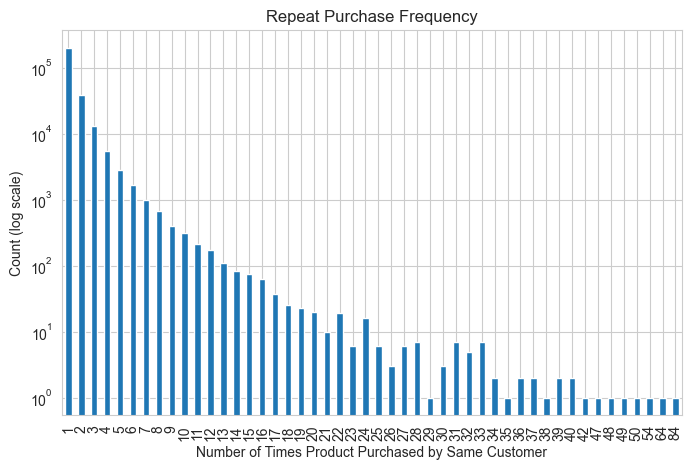

In [13]:
repeat_purchases = (
    clean_df.groupby(["CustomerID", "StockCode"])
            .size()
            .reset_index(name="purchase_count")
)

repeat_distribution = repeat_purchases["purchase_count"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
repeat_distribution.plot(kind="bar")
plt.yscale("log")
plt.title("Repeat Purchase Frequency")
plt.xlabel("Number of Times Product Purchased by Same Customer")
plt.ylabel("Count (log scale)")
plt.show()

<Figure size 800x500 with 0 Axes>

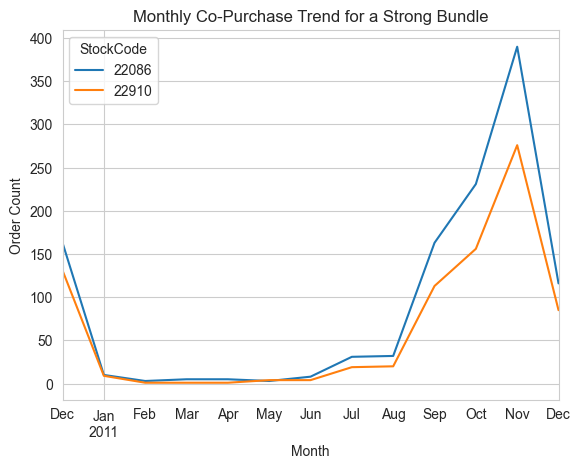

In [14]:
# Pick one strong bundle
top_pair = top_bundles.iloc[0]
prod_a, prod_b = top_pair["product_a"], top_pair["product_b"]

pair_df = clean_df[
    clean_df["StockCode"].isin([prod_a, prod_b])
]

pair_monthly = (
    pair_df.groupby(["month", "StockCode"])["InvoiceNo"]
           .nunique()
           .unstack(fill_value=0)
)

plt.figure(figsize=(8, 5))
pair_monthly.plot()
plt.title("Monthly Co-Purchase Trend for a Strong Bundle")
plt.xlabel("Month")
plt.ylabel("Order Count")
plt.show()

In [16]:
example_product = "85123A"

next_items = (
    co_df[co_df["product_a"] == example_product]
    .sort_values("weighted_score", ascending=False)
    .head(5)
)

next_items.assign(
    Recommended_Product=next_items["product_b"].map(product_name_map)
)[["Recommended_Product", "weighted_score"]]

,Recommended_Product,weighted_score
154220,DOTCOM POSTAGE,59.394665
1841,HAND OVER THE CHOCOLATE SIGN,46.975571
154197,SMALL HANGING IVORY/RED WOOD BIRD,44.728080
4102,LADIES & GENTLEMEN METAL SIGN,36.342060
295879,SET OF 6 3D KIT CARDS FOR KIDS,35.698488


## Key Takeaways

- Customers typically purchase small bundles (2–4 items)
- Strong bundle relationships exist beyond popular products
- Time-aware bundling captures evolving trends
- Bundle recommendations improve customer experience and cross-sell potential
- The system provides actionable insights for both retailers and customers

This insights notebook demonstrates how recommendation systems
can directly support business and product decisions.